<a href="https://colab.research.google.com/github/zevan07/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/Copy_of_LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import normaltest
from scipy.stats import kruskal
from random import randint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [14]:
# the data file does not have a header so we'll need to create one
# attribute info copy and pasted from name file
attribute_info = '''1. Class-Name: 2 (democrat, republican)
   2. handicapped-infants: 2 (y,n)
   3. water-project-cost-sharing: 2 (y,n)
   4. adoption-of-the-budget-resolution: 2 (y,n)
   5. physician-fee-freeze: 2 (y,n)
   6. el-salvador-aid: 2 (y,n)
   7. religious-groups-in-schools: 2 (y,n)
   8. anti-satellite-test-ban: 2 (y,n)
   9. aid-to-nicaraguan-contras: 2 (y,n)
  10. mx-missile: 2 (y,n)
  11. immigration: 2 (y,n)
  12. synfuels-corporation-cutback: 2 (y,n)
  13. education-spending: 2 (y,n)
  14. superfund-right-to-sue: 2 (y,n)
  15. crime: 2 (y,n)
  16. duty-free-exports: 2 (y,n)
  17. export-administration-act-south-africa: 2 (y,n)'''

# clean up attribute info to use for column headers
names = (attribute_info.replace(': 2 (y,n)', ' ')
         .replace(': 2 (democrat, republican)', ' ')
         .replace('.', ' ')
         .split())

# finish cleaning by getting rid of numbers
for x in names:
    nums = [str(x) for x in range(0, 18)]
    if x in nums:
        names.remove(x)
# import the csv without the first row as a header
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None)

# add header (names)
df.columns = names

# replace all 'y', 'n', and '?' values with python friendly values
# replaced '?' with random numbers to avoid NaNs
df = df.replace({'y': 1, 'n': 0, '?': randint(0,1)})
print(df.shape)

# create dataframes for each party
rep = df[df['Class-Name'] == 'republican']
dem = df[df['Class-Name'] == 'democrat']

(435, 17)


In [0]:
# create a function to get mean, confidence interval, and the interval (for use in graphing)
def confidence_interval(data, confidence = 0.95):
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    stderr = stats.sem(data)
    interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return (mean, mean - interval, mean + interval, interval)

# create a reporter for all of the values calculated with the above function
def report_confidence_interval(confidence_interval):
    print('Mean: {}'.format(confidence_interval[0]))
    print('Lower bound: {}'.format(confidence_interval[1]))
    print('Upper bound: {}'.format(confidence_interval[2]))
    s = "our mean lies in the interval [{:.5}, {:.5}]".format(confidence_interval[1], confidence_interval[2])
    return s, confidence_interval[0]

In [81]:
dem_means = []
rep_means = []

dem_er = []
rep_er = []


for name in names[1:]:
    print(name)
    print('Democrats')
    dem_means.append(confidence_interval(dem[name])[0])
    dem_er.append(confidence_interval(dem[name])[3])
    print(report_confidence_interval(confidence_interval(dem[name])))
    print('Republicans')
    rep_means.append(confidence_interval(rep[name])[0])
    rep_er.append(confidence_interval(rep[name])[3])
    print(report_confidence_interval(confidence_interval(rep[name])))
    print(' ')

handicapped-infants
Democrats
Mean: 0.6179775280898876
Lower bound: 0.5593207017612246
Upper bound: 0.6766343544185506
('our mean lies in the interval [0.55932, 0.67663]', 0.6179775280898876)
Republicans
Mean: 0.20238095238095238
Lower bound: 0.14100035693170826
Upper bound: 0.2637615478301965
('our mean lies in the interval [0.141, 0.26376]', 0.20238095238095238)
 
water-project-cost-sharing
Democrats
Mean: 0.5543071161048689
Lower bound: 0.4943030277521611
Upper bound: 0.6143112044575767
('our mean lies in the interval [0.4943, 0.61431]', 0.5543071161048689)
Republicans
Mean: 0.5654761904761905
Lower bound: 0.4897471468537114
Upper bound: 0.6412052340986696
('our mean lies in the interval [0.48975, 0.64121]', 0.5654761904761905)
 
adoption-of-the-budget-resolution
Democrats
Mean: 0.8913857677902621
Lower bound: 0.8538224468450312
Upper bound: 0.9289490887354931
('our mean lies in the interval [0.85382, 0.92895]', 0.8913857677902621)
Republicans
Mean: 0.15476190476190477
Lower bound: 

In [0]:
# bar heights (with a subset of the data)
part_dem_means = dem_means[:5]
part_rep_means = rep_means[:5]

# we need to cut down the names to fit
part_names = names [1:6]

# error bars (with a subset of the data)
part_dem_ers = dem_er[:5]
part_rep_ers = rep_er[:5]

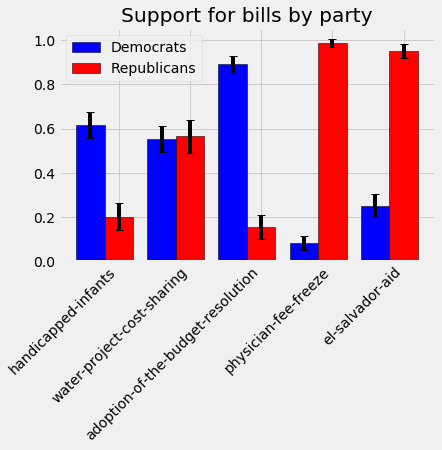

In [84]:
# plot a bar graph
plt.style.use('fivethirtyeight')

barWidth = 0.4
r1 = np.arange(len(part_dem_means))
r2 = [x + barWidth for x in r1]
plt.bar(r1, part_dem_means, width = barWidth, color = 'blue', edgecolor = 'black', yerr = part_dem_ers, capsize = 4, label = 'Democrats')
plt.bar(r2, part_rep_means, width = barWidth, color = 'red', edgecolor = 'black', yerr = part_rep_ers, capsize = 4, label = 'Republicans')

plt.title('Support for bills by party')
plt.legend()

plt.xticks([r + barWidth for r in range(len(part_dem_means))], names[1:6], rotation = 45, ha="right");

## Interpretation

Most of the confidence intervals are pretty large. If you were trying to extrapolate this data to a population (sort of a nonsensical situation, because congress is the population), you might find a value much different from what you predicted. 

Using  the handicapped infants bill as an example, the predicted outcome would be ~62%, but because the confidence interval is ~6%, the actual value could be expected to be anywhere between ~56% and ~68%.

In [78]:
print(dem_means[0])
print(dem_er[0])

0.6179775280898876
0.117313652657326


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)